In [127]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import os
import time#可以用来简单地记录时间
import matplotlib.pyplot as plt#画图
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import  average_precision_score

import torch#深度学习的pytoch平台
from torch import Tensor
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

In [128]:
# from models.lstm import LSTMModel
# from trainer.train_and_evaluate import ModelTrainer, ModelEvaluator
# from data_provider.dataset_generate import TimeSeriesDataset
from models.lstm_itransformer import lstm_itransformerModel

## 加载数据

In [129]:
# database_names_all = ['ams', 'eicu', 'inspire', 'mimiciii', 'mimiciv', 'salz', 'zhejiang']
# database_names_all = ['ams', 'zhejiang', 'inspire', 'salz','eicu', 'mimic']
database_names_all = ['ams', 'zhejiang', 'salz','eicu', 'mimic']
# database_names_all = ['mimiciv']

selected_database_num = -1
internal_database = database_names_all[selected_database_num]  # ''
external_database = database_names_all.copy()
external_database.remove(internal_database) # []
print(internal_database, external_database)

mimic ['ams', 'zhejiang', 'salz', 'eicu']


In [130]:
file_path = "E:\\Research\\Time series research\\Federated learning Time series research\\0.data\\Multi-center time series data\\"
internal_data_path = 'icu_mortality_' + internal_database + '.csv'

In [131]:
df_internal = pd.read_csv(file_path + internal_data_path)
df_internal

,id,gender,age,height,weight,bmi,admission_type,death_hosp,los_icu_day,ethnicity,...,oasis,sapsii,respiration,coagulation,liver,cardiovascular,cns,renal,sofa,mods
0,5,0,1.017520,-0.021828,-0.79298,-0.998913,1,0,1.73,other,...,33.0,35.0,0,1,0,1,4,4,10.0,0
1,5,0,1.017520,-0.021828,-0.79298,-0.998913,1,0,1.73,other,...,33.0,37.0,0,1,0,1,4,4,10.0,0
2,5,0,1.017520,-0.021828,-0.79298,-0.998913,1,0,1.73,other,...,33.0,37.0,0,1,0,1,4,4,10.0,0
3,5,0,1.017520,-0.021828,-0.79298,-0.998913,1,0,1.73,other,...,35.0,37.0,0,1,0,1,4,4,10.0,0
4,5,0,1.017520,-0.021828,-0.79298,-0.998913,1,0,1.73,other,...,33.0,35.0,0,1,0,1,4,4,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918410,76271,1,-0.637632,0.583969,-0.54191,-0.931153,0,0,1.17,white,...,6.0,21.0,2,0,0,1,1,0,4.0,0
3918411,76271,1,-0.637632,0.583969,-0.54191,-0.931153,0,0,1.17,white,...,6.0,21.0,0,0,0,0,0,0,NaN,0
3918412,76271,1,-0.637632,0.583969,-0.54191,-0.931153,0,0,1.17,white,...,6.0,21.0,0,0,0,0,0,0,NaN,0
3918413,76271,1,-0.637632,0.583969,-0.54191,-0.931153,0,0,1.17,white,...,6.0,21.0,0,0,0,0,0,0,NaN,0


In [132]:
print(df_internal.groupby('id')['death_hosp'].last().value_counts())

death_hosp
0    35436
1     5614
Name: count, dtype: int64


In [133]:
train_ids, test_ids = train_test_split(
    df_internal['id'].unique(),  # 按患者ID划分
    test_size=0.2,      # 测试集比例
    random_state=42,    # 随机种子
    stratify=df_internal.groupby('id')['death_hosp'].last()  # 按患者最终标签分层
)
train_ids

array([40804, 52798, 37874, ..., 24565, 47758, 43247], dtype=int64)

In [134]:
len(train_ids), len(test_ids)

(32840, 8210)

In [135]:
# 获取划分后的DataFrame
train_df = df_internal[df_internal['id'].isin(train_ids)]
test_df = df_internal[df_internal['id'].isin(test_ids)]

print("训练集比例:")
print(train_df.groupby('id')['death_hosp'].last().value_counts(normalize=True))
print("\n测试集比例:")
print(test_df.groupby('id')['death_hosp'].last().value_counts(normalize=True))

训练集比例:
death_hosp
0    0.863246
1    0.136754
Name: proportion, dtype: float64

测试集比例:
death_hosp
0    0.863216
1    0.136784
Name: proportion, dtype: float64


In [136]:
print("训练集:")
print(train_df.groupby('id')['death_hosp'].last().value_counts())
print("\n测试集:")
print(test_df.groupby('id')['death_hosp'].last().value_counts())

训练集:
death_hosp
0    28349
1     4491
Name: count, dtype: int64

测试集:
death_hosp
0    7087
1    1123
Name: count, dtype: int64


## 数据生成器

In [137]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, feature_cols, window_size=24, forecast_horizon=24, stride=1, 
                 mode='sliding', shuffle=True, label=['death_hosp'], random_state=42, max_len=None):
        """
        初始化时间序列数据集
        
        参数:
            df: 包含所有数据的DataFrame
            feature_cols: 使用的特征列名列表
            window_size: 输入序列长度
            forecast_horizon: 预测时间范围
            mode: 'sliding'滑动窗口，'cumulative'累积窗口，‘fix’固定时间窗口
            shuffle: 是否打乱数据顺序
            random_state: 随机种子
            label: 标签
        """
        self.df = df
        self.feature_cols = feature_cols
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        self.mode = mode
        self.shuffle = shuffle
        self.random_state = random_state
        self.max_len = max_len
        self.indices = []
        self.stride = stride
        self.label = label
        

        # if len(label)==1:
        #     self.label = label[0]
        # else:
        #     self.label = label
        
        # 预计算所有可能的序列索引
        self._precompute_indices()
        
    def _precompute_indices(self):
        """计算所有有效的序列索引"""
        random.seed(self.random_state)
        
        for pid, group in tqdm(self.df.groupby('id')):
            group = group.sort_values('hr')
            max_hr = group['hr'].max()
            
            if self.mode == 'sliding':
                for start in range(1, max_hr - self.window_size, self.stride):
                    end = start + self.window_size
                    forecast_end = end + self.forecast_horizon
                    if len(group[(group['hr'] >= start) & (group['hr'] < end)]) == self.window_size:
                        y = []
                        for label in self.label:
                            condition = (group['hr'] >= end) & (group['hr'] < forecast_end) & (group[label] == 1)
                            y.append(int(condition.any()))
                        self.indices.append((pid, start, end, y))
                        
            elif self.mode == 'cumulative':
                # for end in range(max_hr, max_hr+1, self.stride):
                # for end in range(13, 14, self.stride):
                for end in range(1, max_hr + 1, self.stride):
                    start = 1
                    forecast_end = end + self.forecast_horizon
                    y = []
                    for label in self.label:
                        condition = (group['hr'] >= end) & (group['hr'] <= forecast_end) & (group[label] == 1)
                        y.append(int(condition.any()))
                    self.indices.append((pid, start, end, y))
                    
            elif self.mode == 'fix':
                start = 1
                end = start + self.window_size
                if len(group[(group['hr'] >= start) & (group['hr'] < end)]) == self.window_size:
                    y = []
                    for label in self.label:
                        condition = (group['hr'] >= end) & (group[label] == 1)
                        y.append(int(condition.any()))
                    self.indices.append((pid, start, end, y))
                        
                    # # condition = (group['hr'] >= end) & (group['death_hosp'] == 1)
                    # condition = group['death_hosp'] == 1
                    # y = int(condition.any())
                    # self.indices.append((pid, start, end, y))
                
        
        if self.shuffle:
            random.shuffle(self.indices)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        pid, start, end, y = self.indices[idx]
        group = self.df[self.df['id'] == pid].sort_values('hr')
        
        # 获取特征序列
        X = group[(group['hr'] >= start) & (group['hr'] <= end)][self.feature_cols].values
        
        # 转换为torch张量
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)

        if self.max_len is not None:
            X_tensor = X_tensor[-self.max_len:]  # 截断到最大长度
            
        seq_len = len(X_tensor)
        
        return X_tensor, y_tensor, seq_len

In [138]:
mask_cols = ['heart_rate', 'sbp', 'mbp', 'dbp', 'resp_rate', 'temperature', 'spo2', 'albumin', 'aniongap', 'bun', 'calcium', 'chloride', 
                'creatinine', 'glucose', 'sodium', 'potassium', 'fibrinogen', 'inr', 'pt', 'ptt', 'hematocrit', 'hemoglobin', 'platelet', 'wbc', 
                'alt', 'ast', 'bilirubin', 'pao2', 'paco2', 'fio2', 'pao2fio2ratio', 'ph', 'baseexcess', 'lactate', 'sao2', 'troponin', 'magnesium', 
                'bnp', 'neutrophils', 'gcs', 'alkaline_phosphatase', 'norepinephrine', 'epinephrine', 'dobutamine', 'dopamine', 'ventilation',
                'lymphocytes', 'bicarbonate', 'urineoutput',]

mask_cols = [i+'_mask' for i in mask_cols]
# mask_cols = mask_cols + ['hr_encode']

In [139]:
# 定义特征列
feature_cols = ['gender', 'age', 'height', 'weight',
                'heart_rate', 'sbp', 'mbp', 'resp_rate', 'temperature', 'spo2', 'albumin', 'aniongap', 'bun', 'calcium', 'chloride', 
                'creatinine', 'glucose', 'sodium', 'potassium', 'fibrinogen', 'inr', 'pt', 'ptt', 'hematocrit', 'hemoglobin', 'platelet', 'wbc', 
                'alt', 'ast', 'bilirubin', 'pao2', 'paco2', 'fio2', 'pao2fio2ratio', 'ph', 'baseexcess', 'lactate', 'sao2', 'troponin', 'magnesium', 
                'bnp', 'neutrophils', 'gcs', 'alkaline_phosphatase', 'norepinephrine', 'epinephrine', 'dobutamine', 'dopamine', 'ventilation',
                'lymphocytes', 'bicarbonate', 'urineoutput', #'hr_encode',
               ]
# # 定义特征列
# feature_cols = ['gender', 'ventilation', 'norepinephrine', 'epinephrine', 'dobutamine', 'dopamine', 'admission_type',
#                 'age', 'height', 'weight', 'bmi',
#                 'heart_rate', 'sbp', 'mbp', 'dbp', 'resp_rate', 'temperature', 'spo2', 'albumin', 'aniongap', 'bun', 'calcium', 'chloride', 
#                 'creatinine', 'glucose', 'sodium', 'potassium', 'fibrinogen', 'inr', 'pt', 'ptt', 'hematocrit', 'hemoglobin', 'platelet', 'wbc', 
#                 'alt', 'ast', 'bilirubin', 'pao2', 'paco2', 'fio2', 'pao2fio2ratio', 'ph', 'baseexcess', 'lactate', 'sao2', 'troponin', 'magnesium', 
#                 'bnp', 'neutrophils', 'gcs', 'alkaline_phosphatase', 'norepinephrine', 'epinephrine', 'dobutamine', 'dopamine', 
#                 'lymphocytes', 'bicarbonate', 'urineoutput',
#                ]
# feature_cols = feature_cols + mask_cols    

# 创建数据集和数据加载器
# train_dataset = TimeSeriesDataset(train_df, feature_cols, window_size=24, forecast_horizon=24, mode='sliding', shuffle=True)
# test_dataset = TimeSeriesDataset(test_df, feature_cols, window_size=24, forecast_horizon=24, mode='sliding', shuffle=False)

# train_dataset = TimeSeriesDataset(train_df, feature_cols, window_size=24, mode='fix', shuffle=False)
# test_dataset = TimeSeriesDataset(test_df, feature_cols, window_size=24, mode='fix', shuffle=False)

train_dataset = TimeSeriesDataset(train_df, feature_cols, mode='cumulative', shuffle=False, stride=4, label=['death_hosp'])
test_dataset = TimeSeriesDataset(test_df, feature_cols, mode='cumulative', shuffle=False, stride=4, label=['death_hosp'])

100%|█████████████████████████████████████████████████████████████████████████████| 8210/8210 [00:17<00:00, 456.33it/s]


In [140]:
# 提取标签列
ys = np.array([y[0] for (pid, start, end, y) in train_dataset.indices])
unique, counts = np.unique(ys, return_counts=True)
label_dist = dict(zip(unique, counts))

print("\n使用numpy统计:")
for label, count in label_dist.items():
    print(f"{label}: {count} 个 ({(count/len(ys))*100:.1f}%)")


使用numpy统计:
0: 764577 个 (96.5%)
1: 27870 个 (3.5%)


In [141]:
# 提取标签列
ys = np.array([y[0] for (pid, start, end, y) in test_dataset.indices])
unique, counts = np.unique(ys, return_counts=True)
label_dist = dict(zip(unique, counts))

print("\n使用numpy统计:")
for label, count in label_dist.items():
    print(f"{label}: {count} 个 ({(count/len(ys))*100:.1f}%)")


使用numpy统计:
0: 194489 个 (96.5%)
1: 6973 个 (3.5%)


In [142]:
train_dataset.indices[:100]

[(5, 1, 1, [0]),
 (5, 1, 5, [0]),
 (5, 1, 9, [0]),
 (5, 1, 13, [0]),
 (5, 1, 17, [0]),
 (5, 1, 21, [0]),
 (5, 1, 25, [0]),
 (5, 1, 29, [0]),
 (5, 1, 33, [0]),
 (5, 1, 37, [0]),
 (5, 1, 41, [0]),
 (10, 1, 1, [0]),
 (10, 1, 5, [0]),
 (10, 1, 9, [0]),
 (10, 1, 13, [0]),
 (10, 1, 17, [0]),
 (10, 1, 21, [0]),
 (10, 1, 25, [0]),
 (10, 1, 29, [0]),
 (10, 1, 33, [0]),
 (10, 1, 37, [0]),
 (10, 1, 41, [0]),
 (10, 1, 45, [0]),
 (10, 1, 49, [0]),
 (10, 1, 53, [0]),
 (10, 1, 57, [0]),
 (10, 1, 61, [0]),
 (10, 1, 65, [0]),
 (10, 1, 69, [0]),
 (10, 1, 73, [0]),
 (10, 1, 77, [0]),
 (10, 1, 81, [0]),
 (10, 1, 85, [0]),
 (10, 1, 89, [0]),
 (10, 1, 93, [0]),
 (10, 1, 97, [0]),
 (10, 1, 101, [0]),
 (10, 1, 105, [0]),
 (10, 1, 109, [0]),
 (10, 1, 113, [0]),
 (10, 1, 117, [0]),
 (10, 1, 121, [0]),
 (10, 1, 125, [0]),
 (10, 1, 129, [0]),
 (10, 1, 133, [0]),
 (10, 1, 137, [0]),
 (10, 1, 141, [0]),
 (10, 1, 145, [0]),
 (10, 1, 149, [0]),
 (10, 1, 153, [0]),
 (11, 1, 1, [0]),
 (11, 1, 5, [0]),
 (11, 1, 9, [0]),

In [143]:
def collate_fn(batch):
    """
    自定义collate函数处理变长序列，生成padding mask
    """
    sequences, targets, lengths = zip(*batch)
    # print(targets)
    
    # 按序列长度排序(降序)
    lengths = torch.tensor(lengths)
    lengths, sort_idx = lengths.sort(descending=True)
    sequences = [sequences[i] for i in sort_idx]
    targets = torch.stack([targets[i] for i in sort_idx])
    
    # 填充序列 (batch_first=True)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    
    # 创建padding mask (1表示有效数据，0表示padding)
    batch_size, max_len = sequences_padded.shape[0], sequences_padded.shape[1]
    padding_mask = torch.arange(max_len).expand(batch_size, max_len) < lengths.unsqueeze(1)
    padding_mask = padding_mask.float().unsqueeze(-1)  # (batch_size, max_len, 1)
    
    return sequences_padded, targets, padding_mask

In [144]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [145]:
len(train_dataset) # 305866 （24-）/ 400904（1-） --stride 8

792447

In [146]:
for x, y, padding_mask in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([16, 657, 52])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


## 检查设备

In [147]:
# Check device 
# Get the GPU device name if available.
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
torch.cuda.empty_cache()
    
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: NVIDIA GeForce RTX 2080


## 定义模型

In [148]:
import torch
import torch.nn as nn


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3, num_class=1):
        """
        LSTM模型初始化
        
        参数:
            input_size: 输入特征维度
            hidden_size: 隐藏层大小
            num_layers: LSTM层数
            dropout: Dropout比率
        """
        super(LSTMModel, self).__init__()
        self.num_class = num_class
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, self.num_class)
        
    def forward(self, x, padding_mask):
        # LSTM层
        lstm_out, _ = self.lstm(x)
        
        # # 只取最后一个时间步的输出
        # last_out = lstm_out[:, -1, :]

        # lstm_out = lstm_out * padding_mask
        # 取每个序列最后一个非padding位置的输出
        batch_size = x.size(0)
        lengths = padding_mask.squeeze(-1).sum(dim=1).long()  # 各序列实际长度
        last_out = lstm_out[torch.arange(batch_size), lengths-1, :]  # (batch_size, hidden_size)
        
        # Dropout和全连接层
        out = self.dropout(last_out)
        out = self.fc(out)

        if self.num_class == 1:
            out = torch.sigmoid(out)
        
        return out

In [149]:
# 初始化模型
# model = LSTMModel(input_size=len(feature_cols), hidden_size=256, num_layers=2, dropout=0.1, num_class=1)
model = lstm_itransformerModel(seq_len=24, d_model=64, d_ff=64, e_layers=3, lstm_layers=2, enc_in=len(feature_cols), num_class=2)
# model = lstm_itransformerModel(seq_len=24, d_model=128, d_ff=256, e_layers=3, enc_in=len(feature_cols), lstm_layers=2, num_class=2)

In [150]:
model_path = "weights_lstmitransformer_cum_24_2_9epoch.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

lstm_itransformerModel(
  (enc_embedding): DataEmbedding_inverted(
    (lstm): LayerNormLSTM(
      (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.1)
      (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (value_projection): Linear(in_features=64, out_features=64, bias=True)
          (out_projection): Linear(in_features=64, out_features=64, bias=True)
        )
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 64, kern

In [151]:
# model.state_dict()

In [152]:
# model.to(device)
# for X, y, padding_mask in train_loader:
#     X, y = X.to(device), y.to(device)
    
#     padding_mask = padding_mask.to(device)
            
#     # 前向传播
#     outputs = model(X,padding_mask)
#     print(X)
#     print(X.shape)
#     print(y.shape)
#     print(outputs)
#     break

In [153]:
# loss = nn.CrossEntropyLoss()(outputs, y.long().squeeze(-1))
# loss

## 训练模型

In [154]:
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import  average_precision_score

# 训练与评估框架
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer,device='cuda'):
        """
        初始化训练器
        参数:
            model: 模型实例
            train_loader: 训练数据加载器
            val_loader: 验证数据加载器
            device: 训练设备
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.best_auc = 0
        self.best_model = None
        
    def train_epoch(self, epoch):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch + 1} [Train]")
        
        for X, y, padding_mask in progress_bar:
            X, y = X.to(self.device), y.to(self.device)
            padding_mask = padding_mask.to(self.device)
            
            # 前向传播
            outputs = self.model(X,padding_mask)
            if y.shape[1] == 1:
                loss = self.criterion(outputs, y.long().squeeze(-1))
                # loss = self.criterion(outputs, y)
            else:
                loss = torch.tensor(0.0, device=self.device)
                for i in range(len(outputs)):
                    loss = loss + self.criterion(outputs[i], y[:, i].long().squeeze(-1))
            # # loss = self.criterion(outputs, y)
            # loss = self.criterion(outputs, y.long().squeeze(-1))
            
            # 反向传播和优化
            self.optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=4.0)
            self.optimizer.step()
            
            total_loss += loss.item() * X.size(0)
            progress_bar.set_postfix(loss=loss.item())
        
        return total_loss / len(self.train_loader.dataset)
    
    def validate(self, testloader):
        """验证模型"""
        self.model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        # total_loss = []
        # preds = []
        # trues = []
        
        with torch.no_grad():
            for X, y, padding_mask in tqdm(testloader, desc="Validating"):
                X, y = X.to(self.device), y.to(self.device)
                padding_mask = padding_mask.to(self.device)
                outputs = self.model(X,padding_mask)
                if y.shape[1] == 1:
                    loss = self.criterion(outputs, y.long().squeeze(-1))
                    # loss = self.criterion(outputs, y)
                else:
                    loss = torch.tensor(0.0, device=self.device)
                    for i in range(len(outputs)):
                        loss = loss + self.criterion(outputs[i], y[:, i].long().squeeze(-1))
                # loss = self.criterion(outputs, y)
                
                val_loss += loss.item() * X.size(0)
                all_preds.extend(outputs.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        
        val_loss /= len(testloader.dataset)
        val_auc = roc_auc_score(all_labels, np.array(all_preds)[:,1])
        val_auprc = average_precision_score(all_labels, np.array(all_preds)[:,1])
        
        # 保存最佳模型
        if val_auc > self.best_auc:
            self.best_auc = val_auc
            self.best_model = self.model.state_dict().copy()
        
        return val_loss, val_auc, val_auprc, np.array(all_preds), all_labels
    
    def train(self, num_epochs=50, early_stop_patience=5):
        """完整训练流程"""
        train_losses = []
        val_losses = []
        val_aucs = []
        
        no_improve = 0
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(epoch)
            val_loss, val_auc, val_auprc = self.validate(self.val_loader)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_aucs.append(val_auc)
            
            print(f"Epoch {epoch + 1}/{num_epochs}:")
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"Val AUC: {val_auc:.4f} | Val AUPRC: {val_auprc:.4f}")

            torch.save(self.model.state_dict(), f'weights_lstmitransformer_cum_24_2_{epoch}epoch.pth')
            # # 早停机制
            # if val_auc > self.best_auc:
            #     no_improve = 0
            # else:
            #     no_improve += 1
            #     if no_improve >= early_stop_patience:
            #         print(f"Early stopping at epoch {epoch + 1}")
            #         break
        
        # 加载最佳模型
        self.model.load_state_dict(self.best_model)
        return train_losses, val_losses, val_aucs

In [155]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) # pt = p if target=1, else 1-p
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [156]:
class MultiClassFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiClassFocalLoss, self).__init__()
        self.alpha = alpha  # 这是一个权重列表，例如 [weight_for_0, weight_for_1]
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 先计算标准的交叉熵损失
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        
        # CrossEntropyLoss = LogSoftmax + NLLLoss。
        # 所以我们先对输入做Softmax，得到概率p
        p = torch.exp(-ce_loss) 
        
        # 计算Focal Loss的调制因子 (1 - p_t)^gamma
        # 注意：对于正确类别，p_t就是p。这里ce_loss = -log(p)，所以p = exp(-ce_loss)
        focal_loss = ((1 - p) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [157]:
total = len(ys)
num_negative = label_dist[0]
num_positive = label_dist[1]

# 按反比设置，让正类的权重远大于负类
weight_for_1 = num_negative / num_positive
weight_for_0 = 1.0  # 将负类权重设为基准 1.0

# 权重张量的顺序对应类别的索引 [weight_for_class_0, weight_for_class_1]
class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float).to(device)
class_weights

tensor([ 1.0000, 27.8917], device='cuda:0')

In [158]:
# 训练模型
# criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([0.9783 / (1-0.9783)]).to(device))
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
# criterion =  nn.CrossEntropyLoss(weight=class_weights)
# 使用FocalLoss方法
# criterion = MultiClassFocalLoss(alpha=class_weights, gamma=2.0)
# criterion = FocalLoss(alpha=100, gamma=2) # alpha可以设置为正样本权重的近似值

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 训练模型
trainer = ModelTrainer(model, train_loader, test_loader, criterion, optimizer)
# train_losses, val_losses, val_aucs = trainer.train(num_epochs=10)

In [159]:
total_loss, auroc, auprc, all_preds, all_labels = trainer.validate(test_loader)

Validating: 100%|████████████████████████████████████████████████████████████████| 12592/12592 [04:44<00:00, 44.32it/s]


In [160]:
auroc

0.8723753267227102

In [161]:
def bootstrap_confidence_interval(probabilities, labels, n_bootstraps=100, confidence_level=0.95):
    """
    使用Bootstrap方法计算置信区间
    
    参数:
    probabilities: 模型输出的概率数组
    labels: 对应的真实标签
    n_bootstraps: Bootstrap采样次数
    confidence_level: 置信水平
    
    返回:
    confidence_interval: 置信区间
    """
    # probabilities = np.array(all_preds).reshape(-1)
    # labels = np.array(labels).reshape(-1)
    # 计算auc
    auroc = roc_auc_score(labels, probabilities)
    
    # Bootstrap采样
    bootstrapped_auc = []
    n_samples = len(probabilities)
    
    for _ in range(n_bootstraps):
        # 有放回抽样
        indices = np.random.choice(n_samples, n_samples, replace=True)
        boot_probs = probabilities[indices]
        boot_labels = labels[indices]
        
        boot_auc = roc_auc_score(boot_labels, boot_probs)
        bootstrapped_auc.append(boot_auc)
    
    # 计算置信区间
    alpha = (1 - confidence_level) / 2
    lower_bound = np.percentile(bootstrapped_auc, 100 * alpha)
    upper_bound = np.percentile(bootstrapped_auc, 100 * (1 - alpha))
    
    return lower_bound, upper_bound, auroc

In [162]:
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1))
lower_bound, upper_bound, auroc

(0.8676350068976376, 0.8765899556164654, 0.8723753267227102)

In [163]:
def draw_auc_curve(all_preds, all_labels, lower_bound, upper_bound, auroc, model_name):
    mean_tpr_xgb = 0.0
    mean_fpr_xgb = np.linspace(0, 1, 100)
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    mean_tpr_xgb += np.interp(mean_fpr_xgb, fpr, tpr)			#对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数
    mean_tpr_xgb[0] = 0.0
    
    # xgboost 平均AUC
    mean_tpr_xgb[-1] = 1.0 #坐标最后一个点为（1,1）
    mean_auc_xgb = auc(mean_fpr_xgb, mean_tpr_xgb)#计算平均AUC值
    
    #画平均ROC曲线
    plt.plot(mean_fpr_xgb, mean_tpr_xgb, label=model_name+':' + '%0.3f (%0.3f, %0.3f)' % (auroc, lower_bound, upper_bound), lw=2)
    
    #画对角线
    # plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    # plt.show()

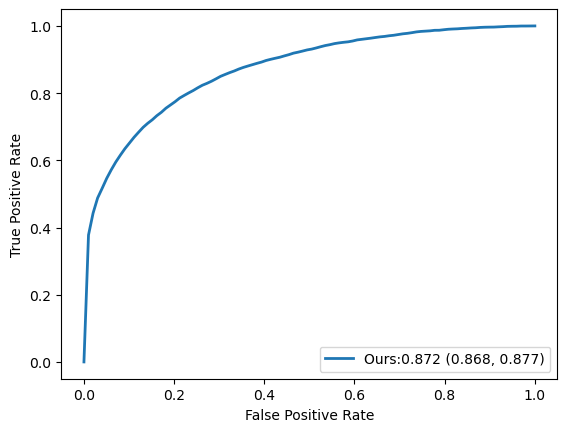

In [164]:
draw_auc_curve(all_preds[:, 1], all_labels, lower_bound, upper_bound, auroc, 'Ours')

In [165]:
def get_sofa_labels(df):
    labels = []
    preds = []
    stride = 4
    for pid, group in tqdm(df.groupby('id')):
        group = group.sort_values('hr')
        max_hr = group['hr'].max()
    
        for end in range(2, max_hr + 1, stride):
            start = 1
            forecast_end = end + 24
    
            condition = (group['hr'] >= end) & (group['hr'] < forecast_end) & (group['death_hosp'] == 1)
            y = int(condition.any())
            X = group[(group['hr'] >= start) & (group['hr'] < end)]['sofa'].values[-1]
            if not pd.isna(X):
                labels.append(y)
                preds.append(X)
    return labels, preds

In [166]:
def get_clinical_scores_labels(df, score_name):
    labels = []
    preds = []
    stride = 4
    for pid, group in tqdm(df.groupby('id')):
        group = group.sort_values('hr')
        max_hr = group['hr'].max()
    
        for end in range(2, max_hr + 1, stride):
            start = 1
            forecast_end = end + 24
    
            condition = (group['hr'] >= end) & (group['hr'] < forecast_end) & (group['death_hosp'] == 1)
            y = int(condition.any())
            X = group[(group['hr'] >= start) & (group['hr'] < end)][score_name].values[-1]
            if not pd.isna(X):
                labels.append(y)
                preds.append(X)
    return labels, preds

In [167]:
sofa_labels, sofa_preds = get_sofa_labels(test_df)
sofa_auroc = roc_auc_score(sofa_labels, sofa_preds)
sofa_auroc

100%|█████████████████████████████████████████████████████████████████████████████| 8210/8210 [00:42<00:00, 195.06it/s]


0.6532327760607316

In [168]:
news_labels, news_preds = get_clinical_scores_labels(test_df, 'news')
news_auroc = roc_auc_score(news_labels, news_preds)
news_auroc

100%|█████████████████████████████████████████████████████████████████████████████| 8210/8210 [00:42<00:00, 195.10it/s]


0.729458576594408

In [169]:
mews_labels, mews_preds = get_clinical_scores_labels(test_df, 'mews')
mews_auroc = roc_auc_score(mews_labels, mews_preds)
mews_auroc

100%|█████████████████████████████████████████████████████████████████████████████| 8210/8210 [00:41<00:00, 195.56it/s]


0.6988969938708656

In [170]:
sapsii_labels, sapsii_preds = get_clinical_scores_labels(test_df, 'sapsii')
sapsii_auroc = roc_auc_score(sapsii_labels, sapsii_preds)
sapsii_auroc

100%|█████████████████████████████████████████████████████████████████████████████| 8210/8210 [00:41<00:00, 195.54it/s]


0.7432733020716442

In [171]:
oasis_labels, oasis_preds = get_clinical_scores_labels(test_df, 'oasis')
oasis_auroc = roc_auc_score(oasis_labels, oasis_preds)
oasis_auroc

100%|█████████████████████████████████████████████████████████████████████████████| 8210/8210 [00:42<00:00, 194.68it/s]


0.6675186641517583

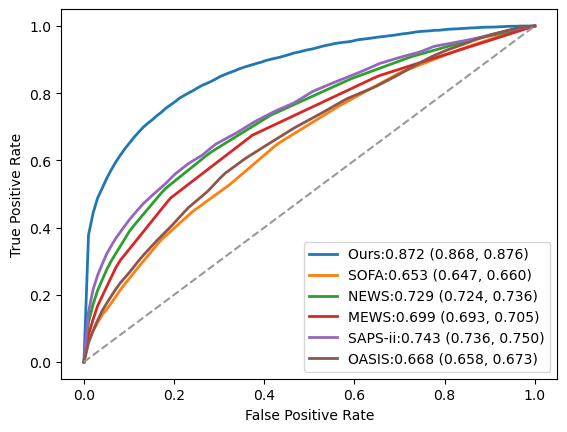

In [172]:
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1))
draw_auc_curve(all_preds[:, 1], all_labels, lower_bound, upper_bound, auroc, 'Ours')

lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(sofa_preds), np.array(sofa_labels))
draw_auc_curve(np.array(sofa_preds), np.array(sofa_labels), lower_bound, upper_bound, sofa_auroc, 'SOFA')

lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(news_preds), np.array(news_labels))
draw_auc_curve(np.array(news_preds), np.array(news_labels), lower_bound, upper_bound, news_auroc, 'NEWS')

lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(mews_preds), np.array(mews_labels))
draw_auc_curve(np.array(mews_preds), np.array(mews_labels), lower_bound, upper_bound, mews_auroc, 'MEWS')

lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(sapsii_preds), np.array(sapsii_labels))
draw_auc_curve(np.array(sapsii_preds), np.array(sapsii_labels), lower_bound, upper_bound, sapsii_auroc, 'SAPS-ii')

lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(oasis_preds), np.array(oasis_labels))
draw_auc_curve(np.array(oasis_preds), np.array(oasis_labels), lower_bound, upper_bound, oasis_auroc, 'OASIS')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

In [173]:
# 如果你还需要计算AUPRC的数值，可以使用以下函数：
from sklearn.metrics import average_precision_score

def bootstrap_confidence_interval_auprc(probabilities, labels, n_bootstraps=100, confidence_level=0.95):
    """
    使用Bootstrap方法计算置信区间
    
    参数:
    probabilities: 模型输出的概率数组
    labels: 对应的真实标签
    n_bootstraps: Bootstrap采样次数
    confidence_level: 置信水平
    
    返回:
    confidence_interval: 置信区间
    """
    # probabilities = np.array(all_preds).reshape(-1)
    # labels = np.array(labels).reshape(-1)
    # 计算auc
    auprc = average_precision_score(labels, probabilities)
    
    # Bootstrap采样
    bootstrapped_auc = []
    n_samples = len(probabilities)
    
    for _ in range(n_bootstraps):
        # 有放回抽样
        indices = np.random.choice(n_samples, n_samples, replace=True)
        boot_probs = probabilities[indices]
        boot_labels = labels[indices]
        
        boot_auc = average_precision_score(boot_labels, boot_probs)
        bootstrapped_auc.append(boot_auc)
    
    # 计算置信区间
    alpha = (1 - confidence_level) / 2
    lower_bound = np.percentile(bootstrapped_auc, 100 * alpha)
    upper_bound = np.percentile(bootstrapped_auc, 100 * (1 - alpha))
    
    return lower_bound, upper_bound, auprc

In [174]:
def draw_auprc_curve(all_preds, all_labels, lower_bound, upper_bound, auprc, model_name):
    mean_precision = 0.0
    mean_recall = np.linspace(0, 1, 100)
    
    # 使用precision_recall_curve代替roc_curve
    precision, recall, thresholds = precision_recall_curve(all_labels, all_preds)
    
    # 对precision在mean_recall处进行插值
    mean_precision += np.interp(mean_recall, recall[::-1], precision[::-1])
    mean_precision[0] = 1.0  # 当recall=0时，precision=1
    
    # 计算平均AUPRC（实际上这里绘制的是精确度-召回率曲线）
    # 注意：这里计算的是曲线下面积，但通常使用average_precision_score来计算AUPRC
    mean_auprc = auc(mean_recall, mean_precision)
    
    # 画平均PR曲线
    plt.plot(mean_recall, mean_precision, label=model_name+':' + '%0.3f (%0.3f, %0.3f)' % (auprc, lower_bound, upper_bound), lw=2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.title('Precision-Recall curve')
    plt.legend(loc="upper right")  # 通常图例放在左下角


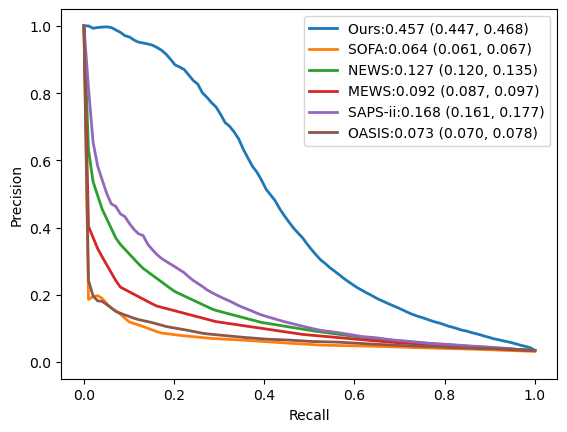

In [175]:
lower_bound, upper_bound, auprc = bootstrap_confidence_interval_auprc(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1))
draw_auprc_curve(all_preds[:, 1], all_labels, lower_bound, upper_bound, auprc, 'Ours')

lower_bound, upper_bound, sofa_auprc = bootstrap_confidence_interval_auprc(np.array(sofa_preds), np.array(sofa_labels))
draw_auprc_curve(np.array(sofa_preds), np.array(sofa_labels), lower_bound, upper_bound, sofa_auprc, 'SOFA')

lower_bound, upper_bound, news_auprc = bootstrap_confidence_interval_auprc(np.array(news_preds), np.array(news_labels))
draw_auprc_curve(np.array(news_preds), np.array(news_labels), lower_bound, upper_bound, news_auprc, 'NEWS')

lower_bound, upper_bound, mews_auprc = bootstrap_confidence_interval_auprc(np.array(mews_preds), np.array(mews_labels))
draw_auprc_curve(np.array(mews_preds), np.array(mews_labels), lower_bound, upper_bound, mews_auprc, 'MEWS')

lower_bound, upper_bound, sapsii_auprc = bootstrap_confidence_interval_auprc(np.array(sapsii_preds), np.array(sapsii_labels))
draw_auprc_curve(np.array(sapsii_preds), np.array(sapsii_labels), lower_bound, upper_bound, sapsii_auprc, 'SAPS-ii')

lower_bound, upper_bound, oasis_auprc = bootstrap_confidence_interval_auprc(np.array(oasis_preds), np.array(oasis_labels))
draw_auprc_curve(np.array(oasis_preds), np.array(oasis_labels), lower_bound, upper_bound, oasis_auprc, 'OASIS')

plt.show()

In [190]:
print( "Ours: \n") 
print(calculate_all_metrics(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1), threshold=-1.68))
print( "sofa: \n") 
print(calculate_all_metrics(np.array(sofa_preds)/10, np.array(sofa_labels), threshold=0.5))
print( "News: \n") 
print(calculate_all_metrics(np.array(news_preds)/10, np.array(news_labels), threshold=0.4))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(mews_preds)/10, np.array(mews_labels), threshold=0.3))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(sapsii_preds)/100, np.array(sapsii_labels), threshold=0.35))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(oasis_preds)/100, np.array(oasis_labels), threshold=0.22))

Ours: 

{'AUROC': 0.8723753267227102, 'Sensitivity': 0.796644199053492, 'Specificity': 0.7737249921589395, 'Accuracy': 0.7745182714358043, 'F1_score': 0.19651195698316118, 'Precision': 0.11207957548978069, 'AUPRC': 0.4566808867657274, 'TP': 5555, 'FP': 44008, 'TN': 150481, 'FN': 1418}
sofa: 

{'AUROC': 0.6532327760607316, 'Sensitivity': 0.6489171144764696, 'Specificity': 0.5708343810242226, 'Accuracy': 0.5732679648999934, 'F1_score': 0.08658149741450484, 'Precision': 0.04638521260374108, 'AUPRC': 0.063719304738272, 'TP': 3985, 'FP': 81926, 'TN': 108970, 'FN': 2156}
News: 

{'AUROC': 0.729458576594408, 'Sensitivity': 0.734490946868507, 'Specificity': 0.5855437906127838, 'Accuracy': 0.5905650087805757, 'F1_score': 0.10790010138118235, 'Precision': 0.05822695452673687, 'AUPRC': 0.12663091268500276, 'TP': 4949, 'FP': 80046, 'TN': 113089, 'FN': 1789}
Mews: 

{'AUROC': 0.6988969938708656, 'Sensitivity': 0.6748293262095577, 'Specificity': 0.626323556061822, 'Accuracy': 0.6279587538086685, 'F1

## 

Database name: ams


Validating: 100%|██████████████████████████████████████████████████████████████████| 5414/5414 [03:41<00:00, 24.48it/s]


total_loss, auroc, auprc:  0.10399491340820317 0.8294380628346677 0.3702983660061395


100%|█████████████████████████████████████████████████████████████████████████████| 2887/2887 [00:17<00:00, 162.49it/s]


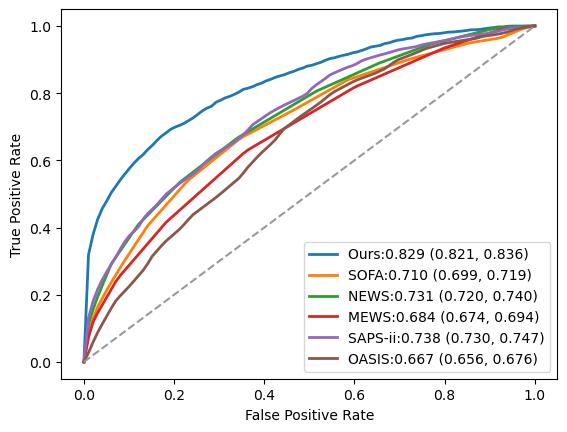

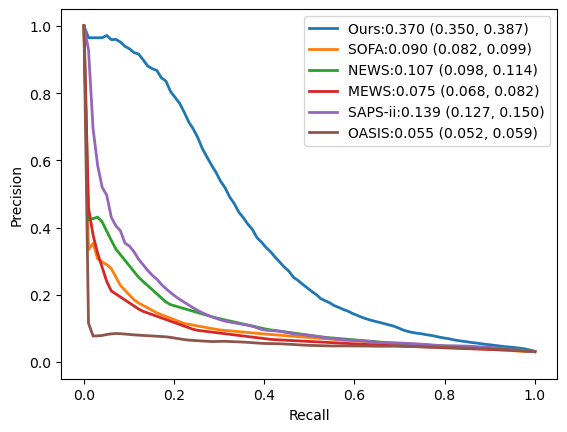

Database name: zhejiang


Validating: 100%|██████████████████████████████████████████████████████████████████| 3717/3717 [02:56<00:00, 21.11it/s]


total_loss, auroc, auprc:  0.10282729920740874 0.8327113291620711 0.3087318947549411


100%|█████████████████████████████████████████████████████████████████████████████| 1247/1247 [00:12<00:00, 100.35it/s]


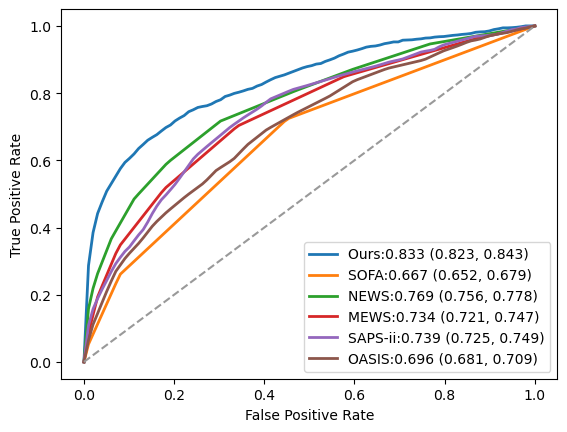

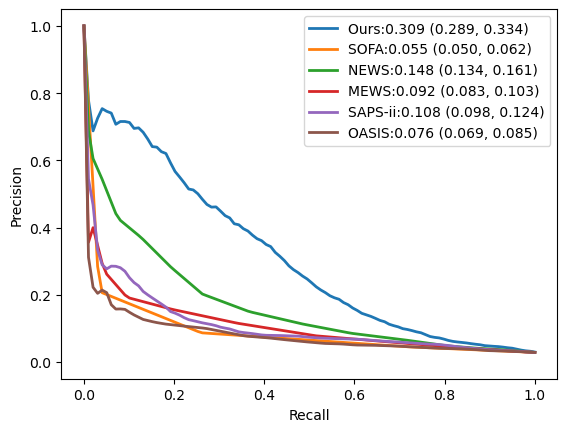

Database name: salz


Validating: 100%|████████████████████████████████████████████████████████████████| 10863/10863 [07:02<00:00, 25.73it/s]


total_loss, auroc, auprc:  0.08986733278287842 0.8055337435602847 0.2970684015097904


100%|█████████████████████████████████████████████████████████████████████████████| 6197/6197 [00:35<00:00, 176.41it/s]


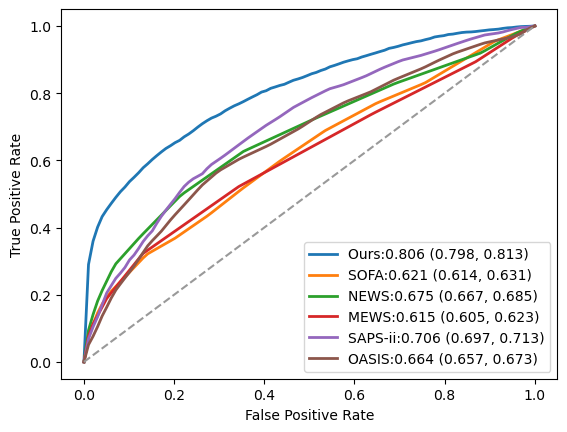

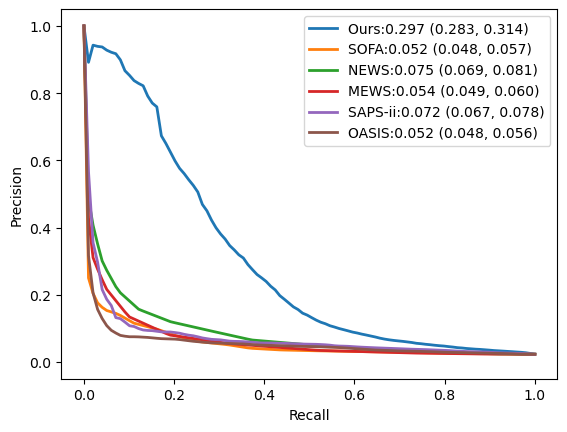

Database name: eicu


Validating: 100%|████████████████████████████████████████████████████████████████| 49059/49059 [43:28<00:00, 18.81it/s]


total_loss, auroc, auprc:  0.11559077125284978 0.800404117789405 0.2229475717545797


100%|███████████████████████████████████████████████████████████████████████████| 36768/36768 [02:43<00:00, 224.54it/s]


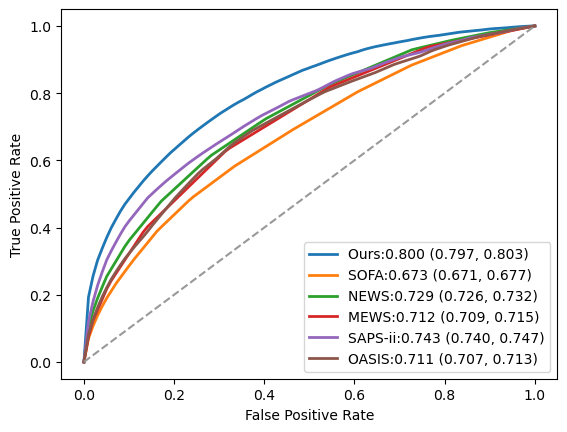

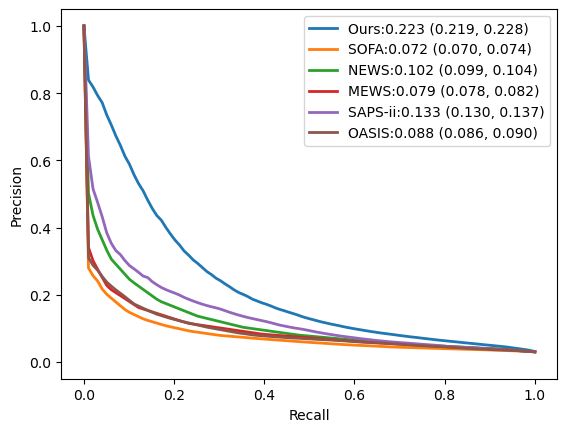

In [65]:
for i in external_database:
    print("Database name: " + i)
    external_data_path = 'icu_mortality_' + i + '.csv'
    df_external = pd.read_csv(file_path + external_data_path)

    external_dataset = TimeSeriesDataset(df_external, feature_cols, mode='cumulative', shuffle=False, stride=4, label=['death_hosp'])
    # external_dataset = TimeSeriesDataset(df_external, feature_cols, window_size=24, forecast_horizon=24, mode='sliding', shuffle=False)
    external_loader = DataLoader(external_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)

    total_loss, auroc, auprc, all_preds, all_labels = trainer.validate(external_loader)
    print("total_loss, auroc, auprc: ", total_loss, auroc, auprc)

    if i=='zhejiang':
        sofa_labels, sofa_preds = get_clinical_scores_labels(df_external, 'qsofa')
    else:
        sofa_labels, sofa_preds = get_sofa_labels(df_external)
    sofa_auroc = roc_auc_score(sofa_labels, sofa_preds)
    news_labels, news_preds = get_clinical_scores_labels(df_external, 'news')
    news_auroc = roc_auc_score(news_labels, news_preds)
    mews_labels, mews_preds = get_clinical_scores_labels(df_external, 'mews')
    mews_auroc = roc_auc_score(mews_labels, mews_preds)
    sapsii_labels, sapsii_preds = get_clinical_scores_labels(df_external, 'sapsii')
    sapsii_auroc = roc_auc_score(sapsii_labels, sapsii_preds)
    oasis_labels, oasis_preds = get_clinical_scores_labels(df_external, 'oasis')
    oasis_auroc = roc_auc_score(oasis_labels, oasis_preds)
    
    lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1))
    draw_auc_curve(all_preds[:, 1], all_labels, lower_bound, upper_bound, auroc, 'Ours')
    lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(sofa_preds), np.array(sofa_labels))
    draw_auc_curve(np.array(sofa_preds), np.array(sofa_labels), lower_bound, upper_bound, sofa_auroc, 'SOFA')
    lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(news_preds), np.array(news_labels))
    draw_auc_curve(np.array(news_preds), np.array(news_labels), lower_bound, upper_bound, news_auroc, 'NEWS')
    lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(mews_preds), np.array(mews_labels))
    draw_auc_curve(np.array(mews_preds), np.array(mews_labels), lower_bound, upper_bound, mews_auroc, 'MEWS')
    lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(sapsii_preds), np.array(sapsii_labels))
    draw_auc_curve(np.array(sapsii_preds), np.array(sapsii_labels), lower_bound, upper_bound, sapsii_auroc, 'SAPS-ii')
    lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(oasis_preds), np.array(oasis_labels))
    draw_auc_curve(np.array(oasis_preds), np.array(oasis_labels), lower_bound, upper_bound, oasis_auroc, 'OASIS')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.show()

    lower_bound, upper_bound, auprc = bootstrap_confidence_interval_auprc(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1))
    draw_auprc_curve(all_preds[:, 1], all_labels, lower_bound, upper_bound, auprc, 'Ours')
    
    lower_bound, upper_bound, sofa_auprc = bootstrap_confidence_interval_auprc(np.array(sofa_preds), np.array(sofa_labels))
    draw_auprc_curve(np.array(sofa_preds), np.array(sofa_labels), lower_bound, upper_bound, sofa_auprc, 'SOFA')
    
    lower_bound, upper_bound, news_auprc = bootstrap_confidence_interval_auprc(np.array(news_preds), np.array(news_labels))
    draw_auprc_curve(np.array(news_preds), np.array(news_labels), lower_bound, upper_bound, news_auprc, 'NEWS')
    
    lower_bound, upper_bound, mews_auprc = bootstrap_confidence_interval_auprc(np.array(mews_preds), np.array(mews_labels))
    draw_auprc_curve(np.array(mews_preds), np.array(mews_labels), lower_bound, upper_bound, mews_auprc, 'MEWS')
    
    lower_bound, upper_bound, sapsii_auprc = bootstrap_confidence_interval_auprc(np.array(sapsii_preds), np.array(sapsii_labels))
    draw_auprc_curve(np.array(sapsii_preds), np.array(sapsii_labels), lower_bound, upper_bound, sapsii_auprc, 'SAPS-ii')
    
    lower_bound, upper_bound, oasis_auprc = bootstrap_confidence_interval_auprc(np.array(oasis_preds), np.array(oasis_labels))
    draw_auprc_curve(np.array(oasis_preds), np.array(oasis_labels), lower_bound, upper_bound, oasis_auprc, 'OASIS')
    
    plt.show()
    

In [ ]:
#欧洲数据集的外部验证

(341758, 75)
(685979, 75)
(1027737, 75)


Validating: 100%|████████████████████████████████████████████████████████████████| 16276/16276 [14:44<00:00, 18.41it/s]


total_loss, auroc, auprc:  0.09456625505943496 0.8156590637872243 0.3236589997577674


100%|█████████████████████████████████████████████████████████████████████████████| 9084/9084 [00:54<00:00, 166.22it/s]


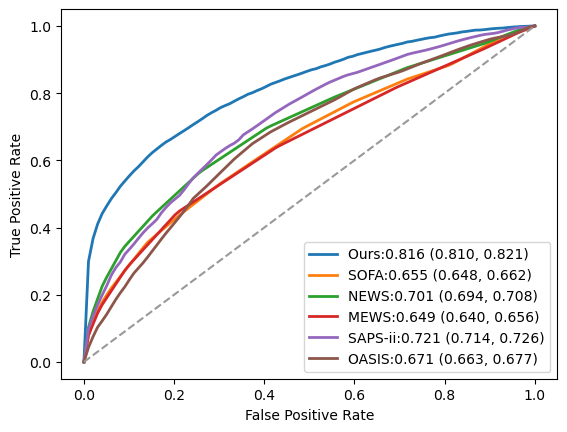

In [191]:
external_data_path = 'icu_mortality_' + 'ams' + '.csv'
df_external_1 = pd.read_csv(file_path + external_data_path)
print(df_external_1.shape)

external_data_path = 'icu_mortality_' + 'salz' + '.csv'
df_external = pd.read_csv(file_path + external_data_path)
print(df_external.shape)

# df_external = pd.concat([df_external, df_external_1], axis=0)
# print(df_external.shape)

# 计算df1的最大id，并顺延df2的id
max_id = df_external_1['id'].max()
df_external['id'] = df_external['id'] + max_id

# 合并DataFrame
df_external = pd.concat([df_external_1, df_external], ignore_index=True)
print(df_external.shape)

external_dataset = TimeSeriesDataset(df_external, feature_cols, mode='cumulative', shuffle=False, stride=4, label=['death_hosp'])
external_loader = DataLoader(external_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)

total_loss, auroc, auprc, all_preds, all_labels = trainer.validate(external_loader)
print("total_loss, auroc, auprc: ", total_loss, auroc, auprc)


sofa_labels, sofa_preds = get_sofa_labels(df_external)
sofa_auroc = roc_auc_score(sofa_labels, sofa_preds)
news_labels, news_preds = get_clinical_scores_labels(df_external, 'news')
news_auroc = roc_auc_score(news_labels, news_preds)
mews_labels, mews_preds = get_clinical_scores_labels(df_external, 'mews')
mews_auroc = roc_auc_score(mews_labels, mews_preds)
sapsii_labels, sapsii_preds = get_clinical_scores_labels(df_external, 'sapsii')
sapsii_auroc = roc_auc_score(sapsii_labels, sapsii_preds)
oasis_labels, oasis_preds = get_clinical_scores_labels(df_external, 'oasis')
oasis_auroc = roc_auc_score(oasis_labels, oasis_preds)

lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1))
draw_auc_curve(all_preds[:, 1], all_labels, lower_bound, upper_bound, auroc, 'Ours')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(sofa_preds), np.array(sofa_labels))
draw_auc_curve(np.array(sofa_preds), np.array(sofa_labels), lower_bound, upper_bound, sofa_auroc, 'SOFA')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(news_preds), np.array(news_labels))
draw_auc_curve(np.array(news_preds), np.array(news_labels), lower_bound, upper_bound, news_auroc, 'NEWS')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(mews_preds), np.array(mews_labels))
draw_auc_curve(np.array(mews_preds), np.array(mews_labels), lower_bound, upper_bound, mews_auroc, 'MEWS')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(sapsii_preds), np.array(sapsii_labels))
draw_auc_curve(np.array(sapsii_preds), np.array(sapsii_labels), lower_bound, upper_bound, sapsii_auroc, 'SAPS-ii')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(oasis_preds), np.array(oasis_labels))
draw_auc_curve(np.array(oasis_preds), np.array(oasis_labels), lower_bound, upper_bound, oasis_auroc, 'OASIS')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.show()

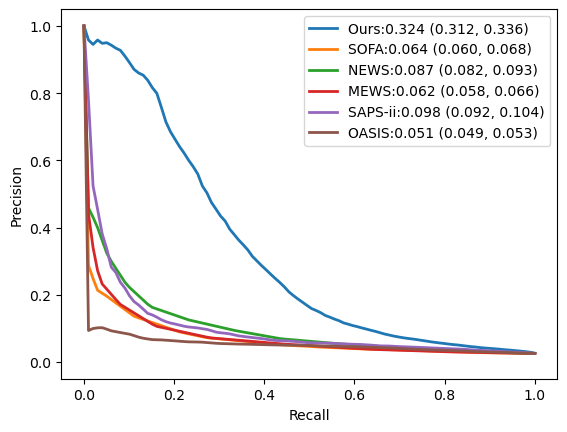

In [192]:
lower_bound, upper_bound, auprc = bootstrap_confidence_interval_auprc(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1))
draw_auprc_curve(all_preds[:, 1], all_labels, lower_bound, upper_bound, auprc, 'Ours')

lower_bound, upper_bound, sofa_auprc = bootstrap_confidence_interval_auprc(np.array(sofa_preds), np.array(sofa_labels))
draw_auprc_curve(np.array(sofa_preds), np.array(sofa_labels), lower_bound, upper_bound, sofa_auprc, 'SOFA')

lower_bound, upper_bound, news_auprc = bootstrap_confidence_interval_auprc(np.array(news_preds), np.array(news_labels))
draw_auprc_curve(np.array(news_preds), np.array(news_labels), lower_bound, upper_bound, news_auprc, 'NEWS')

lower_bound, upper_bound, mews_auprc = bootstrap_confidence_interval_auprc(np.array(mews_preds), np.array(mews_labels))
draw_auprc_curve(np.array(mews_preds), np.array(mews_labels), lower_bound, upper_bound, mews_auprc, 'MEWS')

lower_bound, upper_bound, sapsii_auprc = bootstrap_confidence_interval_auprc(np.array(sapsii_preds), np.array(sapsii_labels))
draw_auprc_curve(np.array(sapsii_preds), np.array(sapsii_labels), lower_bound, upper_bound, sapsii_auprc, 'SAPS-ii')

lower_bound, upper_bound, oasis_auprc = bootstrap_confidence_interval_auprc(np.array(oasis_preds), np.array(oasis_labels))
draw_auprc_curve(np.array(oasis_preds), np.array(oasis_labels), lower_bound, upper_bound, oasis_auprc, 'OASIS')

plt.show()

In [202]:
print( "Ours: \n") 
print(calculate_all_metrics(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1), threshold=-1.85))
print( "sofa: \n") 
print(calculate_all_metrics(np.array(sofa_preds)/10, np.array(sofa_labels), threshold=0.5))
print( "News: \n") 
print(calculate_all_metrics(np.array(news_preds)/10, np.array(news_labels), threshold=0.6))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(mews_preds)/10, np.array(mews_labels), threshold=0.4))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(sapsii_preds)/100, np.array(sapsii_labels), threshold=0.45))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(oasis_preds)/100, np.array(oasis_labels), threshold=0.25))

Ours: 

{'AUROC': 0.8156590637872243, 'Sensitivity': 0.7376252209781968, 'Specificity': 0.7233316904879251, 'Accuracy': 0.7237042697561181, 'F1_score': 0.12217409870066492, 'Precision': 0.06660281735105152, 'AUPRC': 0.3236589997577674, 'TP': 5007, 'FP': 70170, 'TN': 183455, 'FN': 1781}
sofa: 

{'AUROC': 0.6548173428611634, 'Sensitivity': 0.6951070336391437, 'Specificity': 0.5147557672959227, 'Accuracy': 0.5193274444672695, 'F1_score': 0.06830646251859421, 'Precision': 0.03591801905725076, 'AUPRC': 0.0641287127032001, 'TP': 4546, 'FP': 122020, 'TN': 129441, 'FN': 1994}
News: 

{'AUROC': 0.7012559255089404, 'Sensitivity': 0.6980122324159022, 'Specificity': 0.5928434230357789, 'Accuracy': 0.5955093197313188, 'F1_score': 0.08044832538836363, 'Precision': 0.04268389606260928, 'AUPRC': 0.08745725036418948, 'TP': 4565, 'FP': 102384, 'TN': 149077, 'FN': 1975}
Mews: 

{'AUROC': 0.6490768803382149, 'Sensitivity': 0.6399082568807339, 'Specificity': 0.5717069446156661, 'Accuracy': 0.57343576187689

(235970, 68)


Validating: 100%|██████████████████████████████████████████████████████████████████| 3717/3717 [02:55<00:00, 21.14it/s]


total_loss, auroc, auprc:  0.10282729920740874 0.8327113291620711 0.3087318947549411


100%|██████████████████████████████████████████████████████████████████████████████| 1247/1247 [00:12<00:00, 98.66it/s]


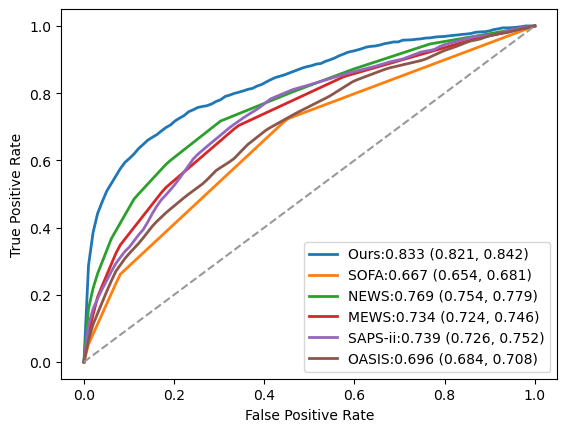

In [68]:
external_data_path = 'icu_mortality_' + 'zhejiang' + '.csv'
df_external = pd.read_csv(file_path + external_data_path)
print(df_external.shape)

# df_external = pd.concat([df_external, df_external_1], axis=0)
# print(df_external.shape)

external_dataset = TimeSeriesDataset(df_external, feature_cols, mode='cumulative', shuffle=False, stride=4, label=['death_hosp'])
external_loader = DataLoader(external_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)

total_loss, auroc, auprc, all_preds, all_labels = trainer.validate(external_loader)
print("total_loss, auroc, auprc: ", total_loss, auroc, auprc)


sofa_labels, sofa_preds = get_clinical_scores_labels(df_external, 'qsofa')
sofa_auroc = roc_auc_score(sofa_labels, sofa_preds)
news_labels, news_preds = get_clinical_scores_labels(df_external, 'news')
news_auroc = roc_auc_score(news_labels, news_preds)
mews_labels, mews_preds = get_clinical_scores_labels(df_external, 'mews')
mews_auroc = roc_auc_score(mews_labels, mews_preds)
sapsii_labels, sapsii_preds = get_clinical_scores_labels(df_external, 'sapsii')
sapsii_auroc = roc_auc_score(sapsii_labels, sapsii_preds)
oasis_labels, oasis_preds = get_clinical_scores_labels(df_external, 'oasis')
oasis_auroc = roc_auc_score(oasis_labels, oasis_preds)

lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1))
draw_auc_curve(all_preds[:, 1], all_labels, lower_bound, upper_bound, auroc, 'Ours')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(sofa_preds), np.array(sofa_labels))
draw_auc_curve(np.array(sofa_preds), np.array(sofa_labels), lower_bound, upper_bound, sofa_auroc, 'SOFA')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(news_preds), np.array(news_labels))
draw_auc_curve(np.array(news_preds), np.array(news_labels), lower_bound, upper_bound, news_auroc, 'NEWS')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(mews_preds), np.array(mews_labels))
draw_auc_curve(np.array(mews_preds), np.array(mews_labels), lower_bound, upper_bound, mews_auroc, 'MEWS')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(sapsii_preds), np.array(sapsii_labels))
draw_auc_curve(np.array(sapsii_preds), np.array(sapsii_labels), lower_bound, upper_bound, sapsii_auroc, 'SAPS-ii')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(oasis_preds), np.array(oasis_labels))
draw_auc_curve(np.array(oasis_preds), np.array(oasis_labels), lower_bound, upper_bound, oasis_auroc, 'OASIS')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.show()

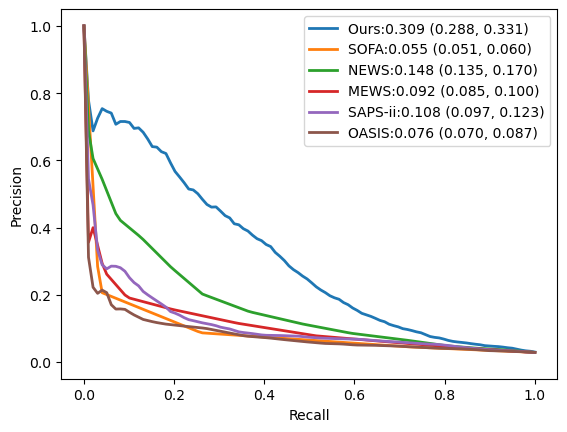

In [69]:
lower_bound, upper_bound, auprc = bootstrap_confidence_interval_auprc(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1))
draw_auprc_curve(all_preds[:, 1], all_labels, lower_bound, upper_bound, auprc, 'Ours')

lower_bound, upper_bound, sofa_auprc = bootstrap_confidence_interval_auprc(np.array(sofa_preds), np.array(sofa_labels))
draw_auprc_curve(np.array(sofa_preds), np.array(sofa_labels), lower_bound, upper_bound, sofa_auprc, 'SOFA')

lower_bound, upper_bound, news_auprc = bootstrap_confidence_interval_auprc(np.array(news_preds), np.array(news_labels))
draw_auprc_curve(np.array(news_preds), np.array(news_labels), lower_bound, upper_bound, news_auprc, 'NEWS')

lower_bound, upper_bound, mews_auprc = bootstrap_confidence_interval_auprc(np.array(mews_preds), np.array(mews_labels))
draw_auprc_curve(np.array(mews_preds), np.array(mews_labels), lower_bound, upper_bound, mews_auprc, 'MEWS')

lower_bound, upper_bound, sapsii_auprc = bootstrap_confidence_interval_auprc(np.array(sapsii_preds), np.array(sapsii_labels))
draw_auprc_curve(np.array(sapsii_preds), np.array(sapsii_labels), lower_bound, upper_bound, sapsii_auprc, 'SAPS-ii')

lower_bound, upper_bound, oasis_auprc = bootstrap_confidence_interval_auprc(np.array(oasis_preds), np.array(oasis_labels))
draw_auprc_curve(np.array(oasis_preds), np.array(oasis_labels), lower_bound, upper_bound, oasis_auprc, 'OASIS')

plt.show()

In [70]:
import numpy as np
from sklearn.metrics import (roc_auc_score, precision_recall_curve, 
                             accuracy_score, f1_score, precision_score, 
                             recall_score, confusion_matrix, average_precision_score)

def calculate_all_metrics(all_preds, all_labels, threshold=0.5):
    # 将概率转换为二分类预测
    binary_preds = (all_preds >= threshold).astype(int)
    
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(all_labels, binary_preds).ravel()
    
    # 计算各项指标
    metrics = {}
    
    # AUROC
    metrics['AUROC'] = roc_auc_score(all_labels, all_preds)
    
    # Sensitivity (Recall)
    metrics['Sensitivity'] = recall_score(all_labels, binary_preds)
    
    # Specificity
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Accuracy
    metrics['Accuracy'] = accuracy_score(all_labels, binary_preds)
    
    # F1 score
    metrics['F1_score'] = f1_score(all_labels, binary_preds)
    
    # Precision
    metrics['Precision'] = precision_score(all_labels, binary_preds)
    
    # AUPRC
    metrics['AUPRC'] = average_precision_score(all_labels, all_preds)
    
    # 额外添加一些可能有用的指标
    metrics['TP'] = tp
    metrics['FP'] = fp
    metrics['TN'] = tn
    metrics['FN'] = fn
    
    return metrics

In [126]:
print( "Ours: \n") 
print(calculate_all_metrics(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1), threshold=-1.85))
print( "sofa: \n") 
print(calculate_all_metrics(np.array(sofa_preds), np.array(sofa_labels), threshold=0.5))
print( "News: \n") 
print(calculate_all_metrics(np.array(news_preds)/10, np.array(news_labels), threshold=0.4))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(mews_preds)/10, np.array(mews_labels), threshold=0.3))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(sapsii_preds)/100, np.array(sapsii_labels), threshold=0.39))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(oasis_preds)/100, np.array(oasis_labels), threshold=0.25))

Ours: 

{'AUROC': 0.8327113291620711, 'Sensitivity': 0.7607573149741824, 'Specificity': 0.7355875831485588, 'Accuracy': 0.7363252677775722, 'F1_score': 0.14465717558501065, 'Precision': 0.07992766726943942, 'AUPRC': 0.3087318947549411, 'TP': 1326, 'FP': 15264, 'TN': 42464, 'FN': 417}
sofa: 

{'AUROC': 0.6668753710123376, 'Sensitivity': 0.7228195937873357, 'Specificity': 0.5498529897875746, 'Accuracy': 0.5547478572515342, 'F1_score': 0.08415049725293831, 'Precision': 0.04467582336434796, 'AUPRC': 0.05517793900142271, 'TP': 1210, 'FP': 25874, 'TN': 31605, 'FN': 464}
News: 

{'AUROC': 0.7685827100575489, 'Sensitivity': 0.7168458781362007, 'Specificity': 0.6970719741122845, 'Accuracy': 0.6976315656010684, 'F1_score': 0.11830819284235433, 'Precision': 0.06447453255963895, 'AUPRC': 0.1475230761489218, 'TP': 1200, 'FP': 17412, 'TN': 40067, 'FN': 474}
Mews: 

{'AUROC': 0.7344142080626486, 'Sensitivity': 0.7019115890083633, 'Specificity': 0.6594756345795856, 'Accuracy': 0.6606765506398661, 'F1_

(3084332, 76)


Validating: 100%|████████████████████████████████████████████████████████████████| 49059/49059 [46:44<00:00, 17.49it/s]


total_loss, auroc, auprc:  0.11559077125284978 0.800404117789405 0.2229475717545797


100%|███████████████████████████████████████████████████████████████████████████| 36768/36768 [02:41<00:00, 228.12it/s]


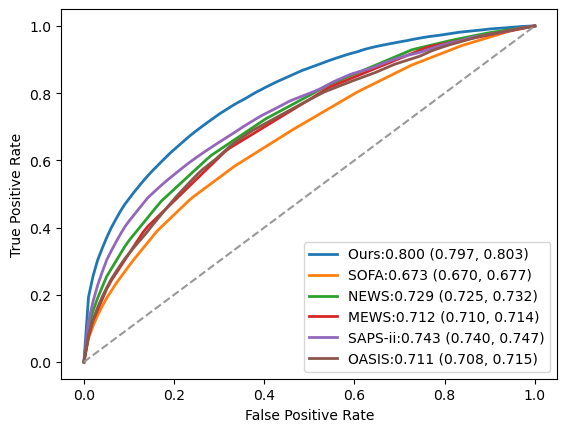

In [203]:
external_data_path = 'icu_mortality_' + 'eicu' + '.csv'
df_external = pd.read_csv(file_path + external_data_path)
print(df_external.shape)

external_dataset = TimeSeriesDataset(df_external, feature_cols, mode='cumulative', shuffle=False, stride=4, label=['death_hosp'])
external_loader = DataLoader(external_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)

total_loss, auroc, auprc, all_preds, all_labels = trainer.validate(external_loader)
print("total_loss, auroc, auprc: ", total_loss, auroc, auprc)


sofa_labels, sofa_preds = get_sofa_labels(df_external)
sofa_auroc = roc_auc_score(sofa_labels, sofa_preds)
news_labels, news_preds = get_clinical_scores_labels(df_external, 'news')
news_auroc = roc_auc_score(news_labels, news_preds)
mews_labels, mews_preds = get_clinical_scores_labels(df_external, 'mews')
mews_auroc = roc_auc_score(mews_labels, mews_preds)
sapsii_labels, sapsii_preds = get_clinical_scores_labels(df_external, 'sapsii')
sapsii_auroc = roc_auc_score(sapsii_labels, sapsii_preds)
oasis_labels, oasis_preds = get_clinical_scores_labels(df_external, 'oasis')
oasis_auroc = roc_auc_score(oasis_labels, oasis_preds)

lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1))
draw_auc_curve(all_preds[:, 1], all_labels, lower_bound, upper_bound, auroc, 'Ours')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(sofa_preds), np.array(sofa_labels))
draw_auc_curve(np.array(sofa_preds), np.array(sofa_labels), lower_bound, upper_bound, sofa_auroc, 'SOFA')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(news_preds), np.array(news_labels))
draw_auc_curve(np.array(news_preds), np.array(news_labels), lower_bound, upper_bound, news_auroc, 'NEWS')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(mews_preds), np.array(mews_labels))
draw_auc_curve(np.array(mews_preds), np.array(mews_labels), lower_bound, upper_bound, mews_auroc, 'MEWS')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(sapsii_preds), np.array(sapsii_labels))
draw_auc_curve(np.array(sapsii_preds), np.array(sapsii_labels), lower_bound, upper_bound, sapsii_auroc, 'SAPS-ii')
lower_bound, upper_bound, auroc = bootstrap_confidence_interval(np.array(oasis_preds), np.array(oasis_labels))
draw_auc_curve(np.array(oasis_preds), np.array(oasis_labels), lower_bound, upper_bound, oasis_auroc, 'OASIS')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.show()

In [237]:
print( "Ours: \n") 
print(calculate_all_metrics(np.array(all_preds)[:, 1].reshape(-1), np.array(all_labels).reshape(-1), threshold=-1.9))
print( "sofa: \n") 
print(calculate_all_metrics(np.array(sofa_preds)/10, np.array(sofa_labels), threshold=0.5))
print( "News: \n") 
print(calculate_all_metrics(np.array(news_preds)/10, np.array(news_labels), threshold=0.5))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(mews_preds)/10, np.array(mews_labels), threshold=0.301))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(sapsii_preds)/100, np.array(sapsii_labels), threshold=0.39))
print( "Mews: \n") 
print(calculate_all_metrics(np.array(oasis_preds)/100, np.array(oasis_labels), threshold=0.22))

Ours: 

{'AUROC': 0.800404117789405, 'Sensitivity': 0.7345533984584313, 'Specificity': 0.7033159891570415, 'Accuracy': 0.7042814791977465, 'F1_score': 0.13311025048270297, 'Precision': 0.07318625719706615, 'AUPRC': 0.2229475717545797, 'TP': 17821, 'FP': 225681, 'TN': 534997, 'FN': 6440}
sofa: 

{'AUROC': 0.6733303664584576, 'Sensitivity': 0.6918709677419355, 'Specificity': 0.5359743405014396, 'Accuracy': 0.5406478382183805, 'F1_score': 0.08282594759917514, 'Precision': 0.044049630455201425, 'AUPRC': 0.07188649966607737, 'TP': 16086, 'FP': 349093, 'TN': 403221, 'FN': 7164}
News: 

{'AUROC': 0.7288363947837956, 'Sensitivity': 0.7227096774193549, 'Specificity': 0.597811552091281, 'Accuracy': 0.6015557710259888, 'F1_score': 0.09808391098139366, 'Precision': 0.052612133072407044, 'AUPRC': 0.10159070787262889, 'TP': 16803, 'FP': 302572, 'TN': 449742, 'FN': 6447}
Mews: 

{'AUROC': 0.7121234349326969, 'Sensitivity': 0.6311827956989248, 'Specificity': 0.6832559277110356, 'Accuracy': 0.681694869